In [1]:
import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score

D:\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 数据预处理
文件夹结构如下：
```
project   
│
└───datasets（存放数据集）
│   │
│   └───corpus.txt （数据集）
│   │
│   └───train.txt, validation.txt, test.txt （标注）
│
└───preprocess_data（存放预处理后的数据）
│
└───model（存放训练好的参数）
    
```
完成以下工作：
- 读入句子、标签
- 统计高频5000词
- 为句子生成5000维的one-hot向量

其中，需要注意数据集和标签并非直接一一对应。可以将标签内容存入字典，其中，key为数据编号,value为标签值。接着，遍历数据集，通过数据编号索引对应标签。

In [11]:
'''
读入数据，提取其中的单词和标注
参数说明：
    input_sentence：原始语料经过split后的一行 
    sentence：句子中的每个单词，为二维list，第一维为行数，第二维为单词（e.g. "措施"）
    word_type：标注，与sentence中的单词一一对应（e.g. "n"）
'''
def read_line(input_sentence,sentence,word_type):
    i = len(sentence)
    sentence.append([])
    word_type.append([])
    word_index_last = 1e9 # 用于确定词的范围
    for count in range(len(input_sentence)): # 对一行的每一个词
        input_word = input_sentence[count]
        for index in range(len(input_word)): 
            # 去除注音 e.g.地方{di4fang1}/n
            if input_word[index] == '{':  
                word_index_last = index
                continue
            # 通过"/"划分词与对应标注 e.g.措施/n
            if input_word[index] == '/': 
                word_index_last = min(index, word_index_last)
                # 处理出现"["的情况 e.g.[保定市/ns  公安局/n]nt
                if input_word[0] != '[':  
                    sentence[i].append(input_word[0:word_index_last])
                else:
                    sentence[i].append(input_word[1:word_index_last])
                # 处理出现"]"的情况
                flag = True 
                for j in range(index + 1, len(input_word)):
                    if input_word[j] == ']':
                        word_type[i].append(input_word[index + 1:j])
                        flag = False
                        break
                if flag:
                    word_type[i].append(input_word[index + 1:])
                break
    if (len(word_type[i])!=len(sentence[i])):
        print("Error: length of sentence and word type do not match!") 
    return sentence,word_type

# 统计5000个最常出现的动词、副词
def count_top5000(sentence_train,word_type_train):
    words = {}
    words5000 = []
    for i in range(len(sentence_train)):
        for j in range(len(sentence_train[i])):
            word = sentence_train[i][j]
            word_type = word_type_train[i][j]
            type_name = ["a","an","c","iv", "jv","lv","qv","Vg","v","vd","vi", "vl","vq","vu","vx","ad","Dg","d","dc","df","id","jd","ld"]
            # 如果当前单词的词性是动词或副词中的一种
            if word_type in str(type_name):
                if word in words:
                    words[word] += 1
                else:
                    words[word] = 1
    # 使用Counter函数对字典进行排序，并选取前5000个最常出现的单词
    words_seq = collections.Counter(words).most_common(5000)
    print("length:", len(words_seq))
    print(words_seq)
    for k, v in words_seq:
        words5000.append(k)
    return words5000

# 生成one-hot向量，用于训练
def generate_one_hot(sentence, words5000):
    output_one_hot = np.zeros((len(sentence),5000),dtype=int)
    word_to_idx = {word: idx for idx, word in enumerate(words5000)}
    for i, sentence_i in enumerate(sentence):
        for word in sentence_i:
            if word in word_to_idx:
                output_one_hot[i][word_to_idx[word]] += 1
    return output_one_hot


# 数据预处理
def data_preprocessing():
    flag_train = True
    flag_validation = False
    flag_test = False
    sentence_train = list()  
    word_type_train = list()  
    sentence_validation = list()  
    word_type_validation = list()  
    sentence_test = list()  
    word_type_test = list() 
    train_label1 = list() 
    train_label2 = list() 
    validation_label1 = list() 
    validation_label2 = list() 
    test_label1 = list() 
    test_label2 = list() 
    train_dict = {}
    val_dict = {}
    test_dict = {}
    with open("dataset/train.txt") as train:
        for i in train:
            i = i.split()
            train_dict[i[0]] = i[1]
    with open("dataset/validation.txt") as val:
        for i in val:
            i = i.split()
            val_dict[i[0]] = i[1]
    with open("dataset/test.txt") as test:
        for i in test:
            i = i.split()
            test_dict[i[0]] = i[1]
    with open("dataset/corpus.txt", 'r+',encoding='utf-8') as corpus:
        for i in corpus: 
            if i[0] == '\n': # 跳过空行
                continue
            if i[:19] == '19980125-12-004-001': # 验证集
                flag_train = False
                flag_validation = True
            if i[:19] == '19980129-02-002-002': # 测试集
                flag_validation = False
                flag_test = True
            line = i.split()
            if len(line) == 0:
                continue
            # 读数据集
            if flag_train:
                if i[:19] in train_dict:
                    sentence_train,word_type_train= \
                        read_line(line,sentence_train,word_type_train)
                    train_label1.append(int(train_dict[i[:19]][1]))
                    train_label2.append(int(train_dict[i[:19]][3]))
            elif flag_validation:
                if i[:19] in val_dict:
                    sentence_validation,word_type_validation = \
                        read_line(line,sentence_validation,word_type_validation)
                    validation_label1.append(int(val_dict[i[:19]][1]))
                    validation_label2.append(int(val_dict[i[:19]][3]))
            elif flag_test:
                if i[:19] in test_dict:
                    sentence_test,word_type_test = \
                        read_line(line,sentence_test,word_type_test)
                    test_label1.append(int(test_dict[i[:19]][1]))
                    test_label2.append(int(test_dict[i[:19]][3]))
    # 统计高频5000词
    words5000 = count_top5000(sentence_train,word_type_train)
    # 生成one-hot向量
    one_hot_train = generate_one_hot(sentence_train, words5000)
    one_hot_validation = generate_one_hot(sentence_validation, words5000)
    one_hot_test = generate_one_hot(sentence_test, words5000)
    # 存储数据
    np.save('preprocess_data/one_hot_train.npy', one_hot_train)
    np.save('preprocess_data/one_hot_validation.npy', one_hot_validation)
    np.save('preprocess_data/one_hot_test.npy', one_hot_test)
    for i in range(len(train_label1)):
        if train_label1[i] != 0 and train_label1[i]!= 1:
            print(train_label1[i])
        if train_label2[i] != 0 and train_label2[i]!= 1:
            print(train_label2[i])
    # 存储标签
    train_label1 = np.reshape(np.array(train_label1),(-1,1))
    train_label2 = np.reshape(np.array(train_label2),(-1,1))
    validation_label1 = np.reshape(np.array(validation_label1),(-1,1))
    validation_label2 = np.reshape(np.array(validation_label2),(-1,1))
    test_label1 = np.reshape(np.array(test_label1 ),(-1,1))
    test_label2 = np.reshape(np.array(test_label2 ),(-1,1))
    np.save('preprocess_data/train_label1.npy', train_label1)
    np.save('preprocess_data/train_label2.npy', train_label2)
    np.save('preprocess_data/validation_label1.npy', validation_label1)
    np.save('preprocess_data/validation_label2.npy', validation_label2)
    np.save('preprocess_data/test_label1.npy', test_label1)
    np.save('preprocess_data/test_label2.npy', test_label2)
    return one_hot_train,one_hot_test,one_hot_validation,train_label1,train_label2,\
        validation_label1,validation_label2,test_label1,test_label2

# 数据处理
one_hot_train,one_hot_test,one_hot_validation,train_label1,train_label2,\
    validation_label1,validation_label2,test_label1,test_label2 = data_preprocessing()


length: 5000
[('和', 8760), ('是', 7930), ('人', 6167), ('不', 5810), ('大', 4293), ('中', 3876), ('国', 3490), ('上', 3459), ('经', 2872), ('全', 2819), ('要', 2654), ('新', 2583), ('电', 2355), ('市', 2352), ('也', 2297), ('等', 2260), ('政', 2190), ('为', 2160), ('就', 2141), ('企', 2070), ('有', 2056), ('进', 1986), ('农', 1953), ('成', 1932), ('地', 1911), ('一', 1868), ('高', 1829), ('文', 1801), ('总', 1792), ('社', 1768), ('公', 1752), ('重', 1738), ('工', 1721), ('而', 1685), ('以', 1683), ('能', 1661), ('主', 1652), ('已', 1611), ('可', 1606), ('同', 1600), ('出', 1592), ('方', 1588), ('都', 1527), ('基', 1498), ('记', 1488), ('之', 1463), ('会', 1461), ('下', 1452), ('好', 1442), ('最', 1435), ('来', 1419), ('并', 1381), ('问', 1361), ('到', 1347), ('产', 1336), ('小', 1335), ('还', 1324), ('世', 1305), ('将', 1302), ('后', 1300), ('', 1299), ('作', 1298), ('部', 1287), ('机', 1281), ('科', 1274), ('资', 1247), ('党', 1233), ('水', 1223), ('多', 1198), ('外', 1196), ('更', 1190), ('生', 1187), ('事', 1182), ('时', 1151), ('但', 1142), ('精', 1102),

# 模型的训练

In [7]:
# 数据导入
one_hot_train = np.load('preprocess_data/one_hot_train.npy', allow_pickle=True)
one_hot_validation = np.load('preprocess_data/one_hot_validation.npy', allow_pickle=True)
one_hot_test = np.load('preprocess_data/one_hot_test.npy', allow_pickle=True)
train_label1 = np.load('preprocess_data/train_label1.npy', allow_pickle=True)
train_label2 = np.load('preprocess_data/train_label2.npy', allow_pickle=True)
validation_label1 = np.load('preprocess_data/validation_label1.npy', allow_pickle=True)
validation_label2 = np.load('preprocess_data/validation_label2.npy', allow_pickle=True)
test_label1 = np.load('preprocess_data/test_label1.npy', allow_pickle=True)
test_label2 = np.load('preprocess_data/test_label2.npy', allow_pickle=True)

print("Input size:","train",one_hot_train.shape,"validation",one_hot_validation.shape,"test",one_hot_test.shape)
print("Label size:","train",train_label1.shape,"validation",validation_label1.shape,"test",test_label1.shape)

Input size: train (15486, 5000) validation (1936, 5000) test (740, 5000)
Label size: train (15486, 1) validation (1936, 1) test (740, 1)


## Pytorch实现
### 逻辑回归模型
包括两层：
- 全连接层 输入为(size, 5000)的one-hot向量，输出维度为(size,1)
- sigmoid激活函数 输出范围为(0,1)

In [3]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(5000, 1), 
            nn.Sigmoid()
             ) 
        # 参数初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    # 前向传播           
    def forward(self, x):
        x = self.net(x)
        return x


X = torch.rand([5,5000])
t = LogisticRegression()
print("Input:  ",X.shape)
for layer in t.net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)
print("Output:  ", X)

Input:   torch.Size([5, 5000])
Linear output shape:	 torch.Size([5, 1])
Sigmoid output shape:	 torch.Size([5, 1])
Output:   tensor([[0.3666],
        [0.4271],
        [0.3370],
        [0.3766],
        [0.6252]], grad_fn=<SigmoidBackward0>)


### 可视化训练过程
可视化损失函数、F1 measure

In [24]:
def visualize(epoch):
    x = np.array(range(0, epoch+1,1))
    loss1 = np.array(Loss_train)
    loss2 = np.array(Loss_val)
    plt.figure()
    plt.xlabel('Epochs', fontdict={'family': 'Times New Roman', 'size': 14})
    plt.ylabel('Loss', fontdict={'family': 'Times New Roman', 'size': 14})
    plt.plot(x, loss1,color=(1,0.84,0), linewidth=1.0, label='training set')
    plt.plot(x, loss2, color=(1,0.5,0), linewidth=1.0, label='validation set')
    plt.legend()
    plt.show()
    
    plt.figure()
    x2 = np.array(range(10, epoch+1,1))
    plt.xlabel('Epochs', fontdict={'family': 'Times New Roman', 'size': 14})
    plt.ylabel('F1 measure', fontdict={'family': 'Times New Roman', 'size': 14})
    y1 = np.array(F1_train)
    y2 = np.array(F1_val)
    plt.plot(x2, y1, linewidth=1.0, label='training set')
    plt.plot(x2, y2, linewidth=1.0, label='validation set')
    plt.legend()
    plt.show()

### 训练

In [10]:
one_hot_train_tensor = torch.from_numpy(one_hot_train).float()
train_label1_tensor = torch.from_numpy(train_label1).float()
one_hot_validation_tensor = torch.from_numpy(one_hot_validation).float()
validation_label1_tensor = torch.from_numpy(validation_label1).float()
one_hot_test_tensor = torch.from_numpy(one_hot_test).float()
test_label1_tensor = torch.from_numpy(test_label1).float()

Loss_train = []
Loss_val = []
F1_train = []
F1_val = []
bestF1 = 0

dataset = TensorDataset(one_hot_train_tensor, train_label1_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True) 
model = LogisticRegression() # 模型初始化
criterion = nn.BCELoss() # 损失函数
optimizer = optim.SGD(model.parameters(), lr=0.008) # 优化器

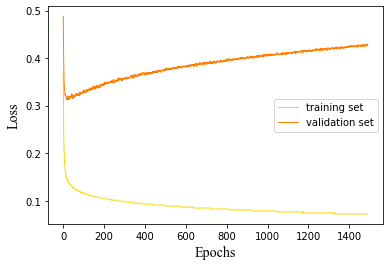

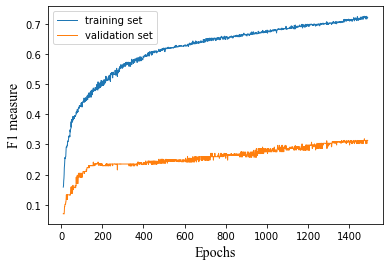

In [27]:
for epoch in range(1500):
    tmp = 0
    for batch in dataloader:
        inputs, labels = batch
        optimizer.zero_grad() # 清空梯度
        outputs = model(inputs) # forward
        loss = criterion(outputs, labels) # 计算损失函数
        loss.backward() # 反向传播
        optimizer.step() # 更新参数
        tmp += loss
    Loss_train.append(int(tmp)/len(dataloader))
    with torch.no_grad():
        # 计算验证集loss
        output_val = model(one_hot_validation_tensor)
        loss2 = criterion(output_val, validation_label1_tensor)
        Loss_val.append(loss2.item())
        # 计算训练集、验证集 F1
        if epoch >= 10:
            predicted_labels = torch.round(model(one_hot_train_tensor))
            f1 = f1_score(train_label1_tensor, predicted_labels)
            F1_train.append(f1)
            
            predicted_labels_val = torch.round(output_val)
            f1_val = f1_score(validation_label1_tensor, predicted_labels_val)
            F1_val.append(f1_val)   
            
            # 存储验证集参数
            if f1_val > bestF1:
                bestF1 = f1_val
                torch.save(obj=model.state_dict(), f="model/net1.pth")
            
    if epoch % 10 == 0 and epoch >= 10:
        display.clear_output(wait=True)
        visualize(epoch)

### 测试

In [12]:
model_test = LogisticRegression()
model_test.load_state_dict(torch.load("model/net1.pth"))
print(model_test.state_dict())
with torch.no_grad():
    output_test = model_test(one_hot_test_tensor)
    loss_test = criterion(output_test, test_label1_tensor)
    predicted_labels_test = torch.round(output_test)
    f1_test = f1_score(test_label1_tensor, predicted_labels_test)
print("loss:",loss_test.item(),"f1:",f1_test)

OrderedDict([('net.0.weight', tensor([[ 0.2126, -0.3003, -0.0009,  ..., -0.0671,  0.0413, -0.0071]])), ('net.0.bias', tensor([-4.1021]))])
loss: 0.34351271390914917 f1: 0.2941176470588235


## Numpy手写实现
将模型的前向传播、反向传播、参数更新、训练、F1计算、可视化封装于类`RegressionModel`。

In [14]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))    

class RegressionModel:
    def __init__(self, lr=0.005,iter_num=100000,batch_size=32,weight_init=0.01):
        self.W = weight_init * np.random.randn(5000, 1)  # 参数 (5000, 1)
        self.size = batch_size # batch大小
        self.lr = lr # 学习率
        self.iter_num = iter_num # 迭代次数
        self.loss_store = [] # 存储所有损失
        self.loss_val_store = []
        self.F1_train_store = [] # 存储所有F1
        self.F1_val_store = [] 
        self.plot = 500
        self.best_F1 = 0
    
    def forward(self, x, t):
        # Affine
        out = np.dot(x, self.W)  # (size, 1)
        # Sigmoid
        y = sigmoid(out)  # (size, 1)
        # loss
        loss = t * np.log(y) + (1 - t) * np.log(1 - y) 
        loss = -1 / len(x) * sum(loss)
        return y, loss

    def backward(self,x,y,t):
        # 手动求导 (5000,size)*(size,1) = (5000,1)
        dW = np.dot(x.transpose(), (y - t))
        dW = 1 / len(x) * dW
        return dW

    def gradient_descent(self, x, t):
        y,loss = self.forward(x,t)
        dW = self.backward(x,y,t)
        self.W -= self.lr * dW  # 对参数进行更新
        return loss
    
    def train(self, one_hot, label, one_hot_val, label_val):
        # 初始化
        train_size = one_hot.shape[0]
        loss_tmp = 0
        # pbar = tqdm(self.iter_num)
        for i in range(self.iter_num):
            batch_position = np.random.choice(train_size,self.size)
            x_input = one_hot[batch_position]
            label_input = label[batch_position]
            loss = self.gradient_descent(x_input, label_input) # 计算损失函数的导数
            loss_tmp += loss
            # pbar.set_description("Iter:{} Loss:{:.4f}".format(i, loss.item()))
            if i % self.plot == 0 and i!= 0:
                self.loss_store.append(loss_tmp/self.plot)
                loss_tmp = 0
                _,loss_val = self.forward(one_hot_val, label_val)
                self.loss_val_store.append(loss_val)
                F1_train = self.evaluate(one_hot, label)
                F1_val = self.evaluate(one_hot_val, label_val)
                self.F1_train_store.append(F1_train)
                self.F1_val_store.append(F1_val)
                if F1_val > self.best_F1:
                    self.best_F1 = F1_val
                    np.save("model/net2.npy",self.W)
            if i % 1000 == 0:
                display.clear_output(wait=True)
                self.visualize(i)
                
    # 可视化训练
    def visualize(self, cur_iteration):
        x = np.array(range(1, cur_iteration + 1,self.plot))
        loss = np.array(self.loss_store)
        loss_val = np.array(self.loss_val_store)
        F1_train = np.array(self.F1_train_store)
        F1_val = np.array(self.F1_val_store)
        plt.figure()
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.plot(x, loss, 'darkviolet',color=(1,0.84,0), linewidth=1.0, label='training set')
        plt.plot(x, loss_val, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='validation set')
        plt.legend()
        plt.show()

        plt.figure()
        plt.xlabel('Iterations')
        plt.ylabel('F1 score')
        plt.plot(x, F1_train, 'darkviolet',color=(1,0.5,0), linewidth=1.0, label='training set')
        plt.plot(x, F1_val, linewidth=1.0, label='validation set')
        plt.legend()
        plt.show()
    
    # 计算F1
    def evaluate(self, one_hot, label):
        out, loss = self.forward(one_hot,label)
        y = np.where(out > 0.5, 1, 0)
        TP = np.sum((y == 1) & (label == 1))
        FP = np.sum((y == 1) & (label == 0))
        FN = np.sum((y == 0) & (label == 1))
        # print("TP+FP",TP+FP,"TP", TP, "TP+FN", TP+FN, "loss", loss)
        if TP+FP != 0:
            precision  = TP/(TP+FP)
        else:
            precision = 0
        recall = TP/(TP+FN)
        if precision == 0 and recall == 0:
            F1 = 0
        else:
            F1 = 2*precision*recall/(precision+recall)
        return F1

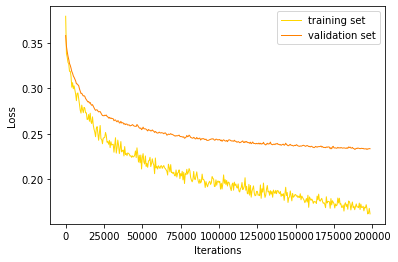

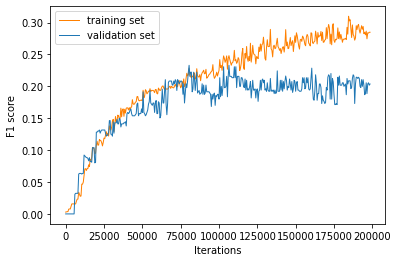

In [41]:
iter_num = 200000
batch_size = 32
learning_rate = 0.008
weight_init = 0.01

model2 = RegressionModel(learning_rate,iter_num,batch_size,weight_init)
model2.train(one_hot_train, train_label2, one_hot_validation, validation_label2)

In [15]:
model2_test = RegressionModel()
model2_test.W = np.load("model/net2.npy")
output2_test,loss2_test = model2_test.forward(one_hot_test, test_label2)
f1_test =model2_test.evaluate(one_hot_test, test_label2)
print("loss:",loss2_test,"f1:",f1_test)

loss: [0.30535115] f1: 0.17241379310344826
